# Testing STructured Additive REGression for nasty data distributions

- bulk data vs well-distributed data
- equidistant vs quantile based


## ToDo
- [x] Single point prediction
- [x] Extrapolation
- [x] Klemmen
- [x] Cost function partitioning
- [x] Multi-peak
- [ ] Confidence Intervals
- [ ] Data Preprocessing

## IMPORTS

In [63]:
import numpy as np
import pandas as pd
import copy
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import ParameterGrid
from scipy.signal import find_peaks
from sklearn.utils import check_X_y 
from sklearn.metrics import mean_squared_error

from stareg.utils import check_constraint
from stareg import StarModel 
from stareg.utils import check_constraint_full_model, bar_chart_of_coefficient_difference_dataframe
from stareg import Smooths as s

### 2D Test Case

In [3]:
# try CV on multi dim dataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

m2 = ( ('s(1)', 'smooth', 25, (1, 1000), "quantile"), 
       ('s(2)', 'inc', 25, (2, 2000), "quantile"),  
     )# ('t(1,2)', 'smooth', (5, 5), (3, 3000), "quantile"), )

M2 = StarModel(description=m2)

X = pd.DataFrame(data={"x1": np.linspace(-2,2,1000),   
                       "x2": np.linspace(0,1,1000), }) #,
                       #"x3": np.linspace(-2,2,1000), "x4": np.linspace(0,1,1000),
                       #"x5": np.linspace(-2,2,1000), "x6": np.linspace(0,1,1000)})
y = pd.DataFrame(data={"y": 2*np.exp(-X["x1"]**2) + 0.1*np.exp(X["x2"]) + 
                       0.1*np.random.randn(len(X["x1"])) + X["x1"] * X["x2"]  })

X_norm = MinMaxScaler().fit_transform(X)
y_norm = MinMaxScaler().fit_transform(y)

f2 = M2.fit(X=X_norm, y=y_norm.ravel(), plot_=False)
# M2.calc_GCV(X=X_norm, y=y_norm.ravel(), n_grid=2)

### 1D Test Case

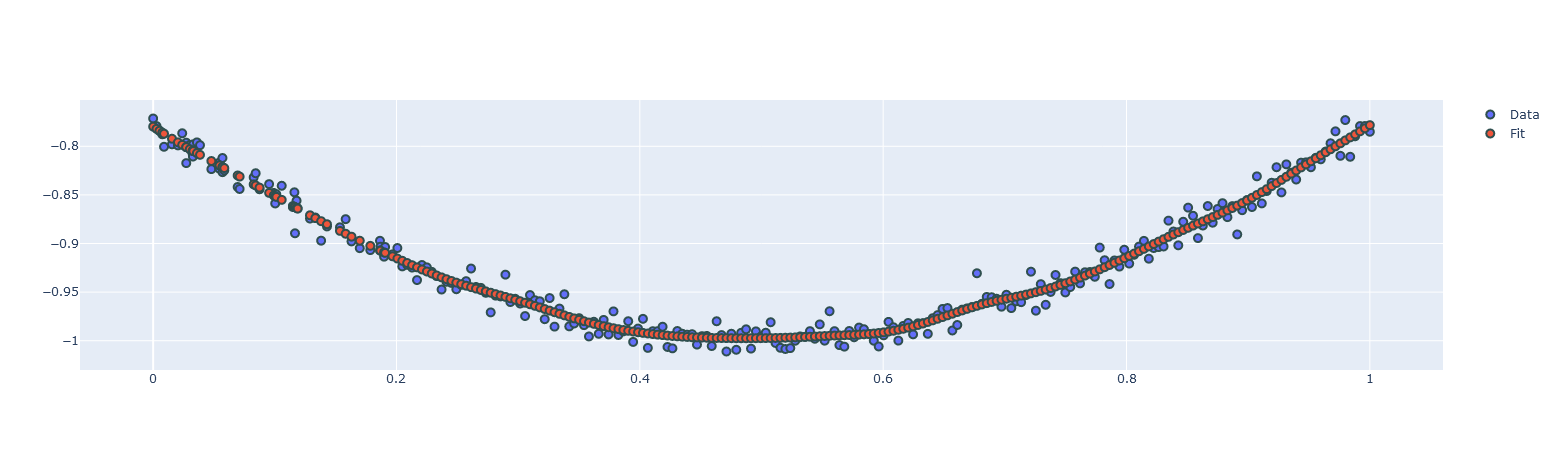

Violated Constraints: 0 from 35 


In [70]:
# try CV on 1-d dataset

# generate data
np.random.seed(42)
x_dense = np.random.random(50) * 0.2
x_sparse = np.linspace(0.2,1,200)
x_dense.sort()
x=np.concatenate((x_dense, x_sparse))
x = (x - x.min()) / (x.max() - x.min())
n_samples = len(x)
x = x.reshape((len(x), 1))
y = -np.exp(-(x-0.5)**2) + 0.01*np.random.randn(len(x), 1)

x_ep = np.concatenate((np.linspace(-0.5,0,103), np.linspace(1, 1.5, 103)))
y_ep_true = -20*np.exp(-(x_ep-0.5)**2) + 0.1*np.random.randn(len(x_ep),1)


# generate parameter grid

m1 = (("s(1)", "valley", 35, (1, 1000), "quantile"),)
M1 = StarModel(description=m1)
y_pred = M1.fit(X=x, y=y.ravel(), plot_=True)
#M1.calc_GCV(X=x, y=y.ravel(), n_grid=2, p_min=1e-2, plot_=True)
y_ep = M1.predict(X_pred=x_ep, extrapol_type="zero", depth=3)

In [66]:
np.cov(y.ravel())

array(1.93162647)

In [128]:
x = np.linspace(0,14,11)
b1 = 0.5
b0 = 3.0
se = 1.237
n = 11
ci = 0.95

In [129]:
from scipy.stats import t

In [130]:
np.sum((x - x.mean())**2)

215.59999999999997

In [126]:
se_b0 = se**2 * (1/n + x.mean()**2 / np.sum((x - x.mean())**2))
se_b1 = se**2 / np.sum((x - x.mean())**2)
ct = t.ppf(ci, df=n-2)
print("se_b0 = ", se_b0)
print("se_b1 = ", se_b1)

se_b0 =  0.18410233144014407
se_b1 =  0.0009182869125075777


In [123]:
b1_m, b1_p = b1 - ct*se, b1 + ct*se_b1

In [124]:
print("Left : ", b1_m)
print("Right : ", b1_p)

Left :  -1.7675606976925446
Right :  0.5016833236152042


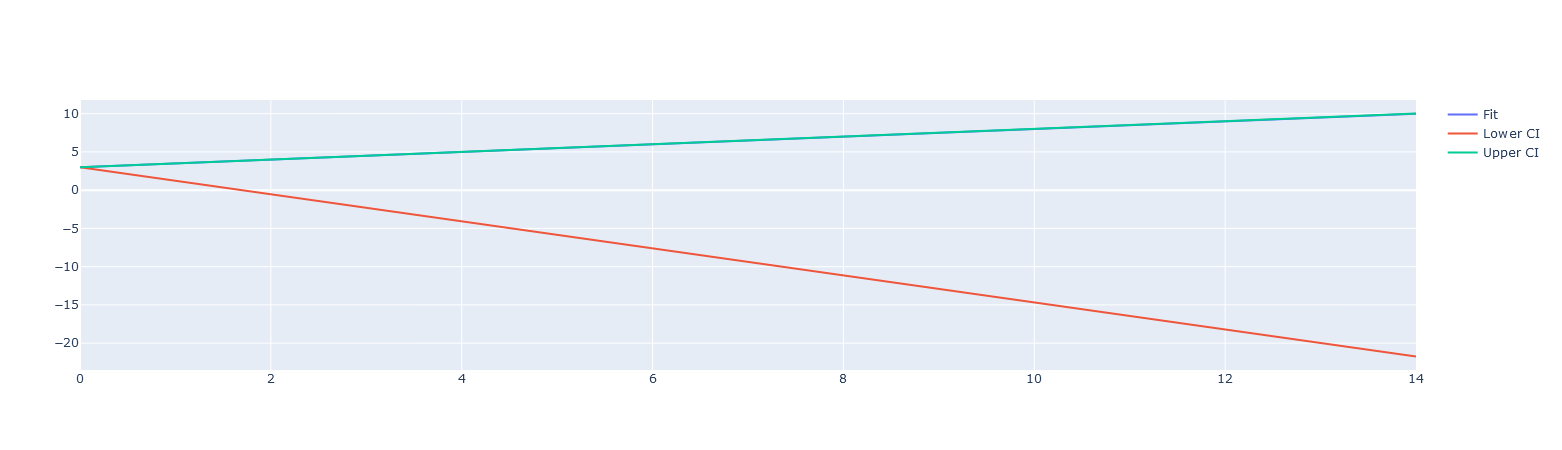

In [125]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=b0+b1*x, name="Fit"))
fig.add_trace(go.Scatter(x=x, y=b0+b1_m*x, name="Lower CI"))
fig.add_trace(go.Scatter(x=x, y=b0+b1_p*x, name="Upper CI"))


**Extrapolation Behaviour for the 1D Test Case**

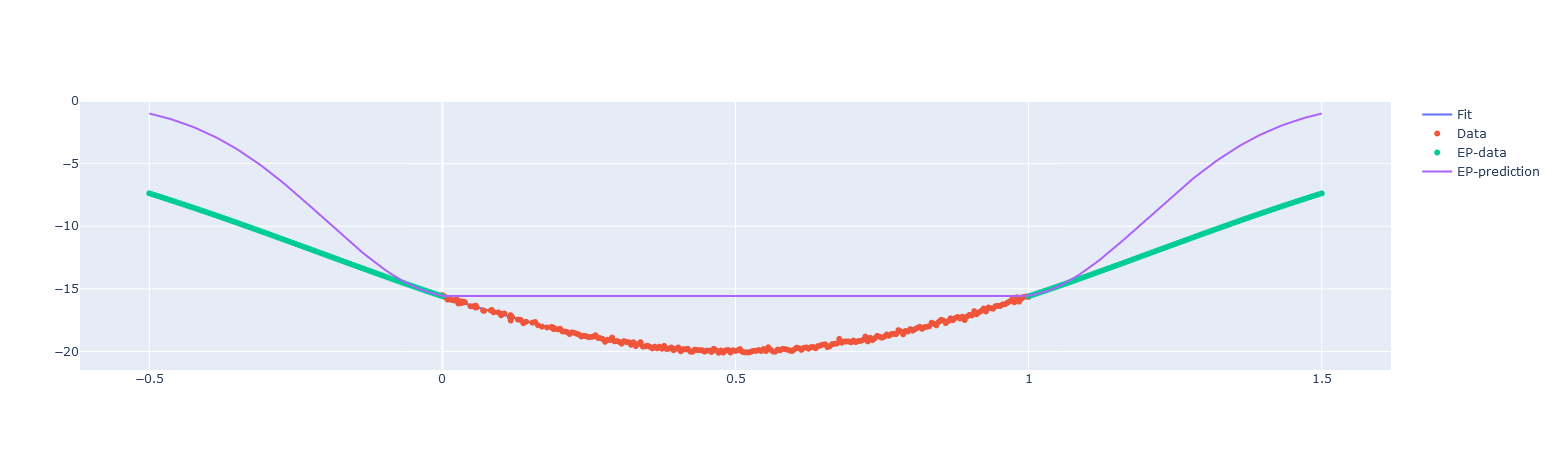

In [3]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.ravel(), y=M1.basis @ M1.coef_, name="Fit"))
fig.add_trace(go.Scatter(x=x.ravel(), y=y.ravel(), mode="markers", name="Data"))
fig.add_trace(go.Scatter(x=x_ep.ravel(), y=y_ep_true.ravel(), mode="markers", name="EP-data"))
fig.add_trace(go.Scatter(x=x_ep.ravel(), y=y_ep.ravel(), name="EP-prediction"))
fig.show()

# Extrapolation

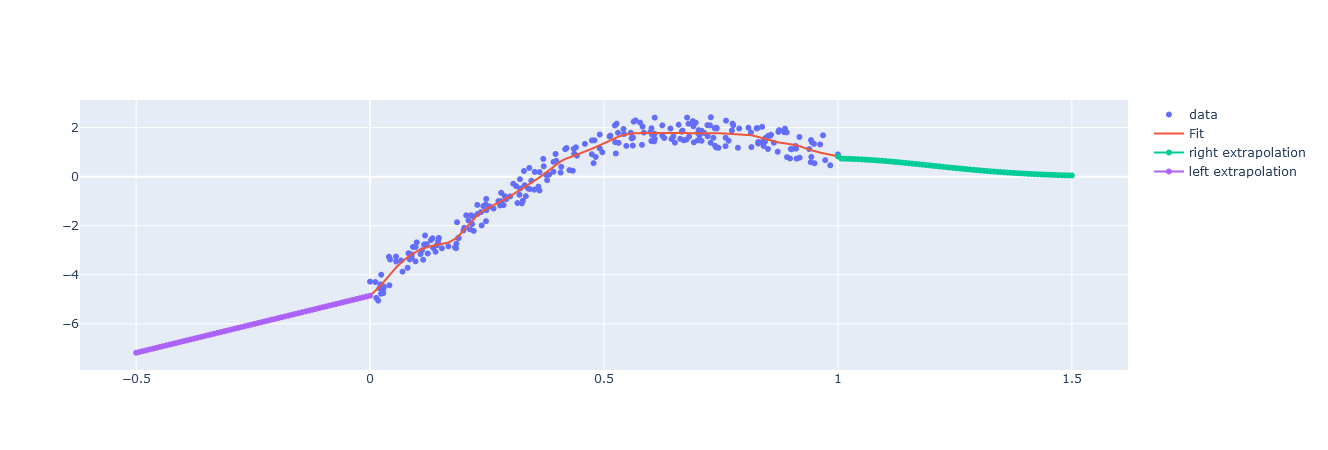

In [11]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from stareg import StarModel 
from stareg.bspline import Bspline

# test with different dataset
np.random.seed(41)
x = np.random.random(250)
x.sort()
xmax, xmin = x.max(), x.min()
x = x
x = (x - xmin) / (xmax - xmin)
noise = np.random.random(250)*1.25
y = 2*np.exp(-(x - 0.4)**2 / 0.1) - 5.5*x**2 + noise
y = y
y = np.flip(y)
n_param = 25
descr = ( ("s(1)", "peak", n_param, (0.01, 1000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=False)

# extrapolation
x_right = np.linspace(1,1.5,70)
x_left = np.linspace(-0.5,0,70)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="data"))
fig.add_trace(go.Scatter(x=x, y=M.basis @ M.coef_, name="Fit"))
fig.add_trace(go.Scatter(x=x_right, y=M.predict(X_pred=x_right, extrapol_type="zero", depth=5), mode="markers+lines", name="right extrapolation"))
fig.add_trace(go.Scatter(x=x_left, y=M.predict(X_pred=x_left, extrapol_type="linear", depth=13), mode="markers+lines", name="left extrapolation"))

# Multi-Peak

- [x] test if the "security" non-constraint splines (4 splines in the peak region are currently not constraint) in the peak and valley constraint are really needed for smooth function fitting.
        -> not needed, changed to only one non-constraint spline
- [x] implement multi-peak
- [x] implement multi-valley
- [x] implement peak-valley or other way
        -> basics work, but it needs polishing
- [ ] think of a way to specify multi-peak in the model description
- [ ] Testing !

**Test for  Multi Peak Data**

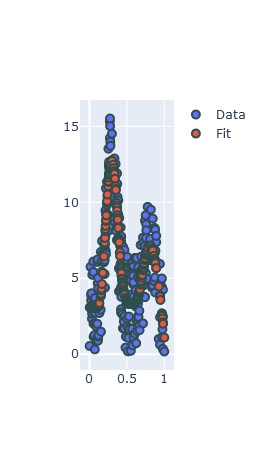

Violated Constraints: 3 from 15 


StarModel(s(1)={'constraint': 'multi-peak', 'knot_type': 'equidistant',
                'lam': {'constraint': 100000, 'smoothness': 0.01},
                'n_param': 15})

In [5]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*1.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 4*np.exp(-(x-0.8)**2/0.01) + 5*noise

descr = ( ("s(1)", "multi-peak", 15, (0.01, 100000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

**Test for Multi-Valley Data**

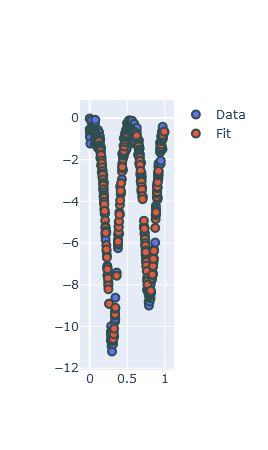

Violated Constraints: 4 from 35 


StarModel(s(1)={'constraint': 'multi-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 1200, 'smoothness': 0.1}, 'n_param': 35})

In [6]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*1.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) + 8*np.exp(-(x-0.8)**2/0.01) + noise
y = -1*y
descr = ( ("s(1)", "multi-valley", 35, (0.1, 1200), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

**Test for Peak-Valley Data**

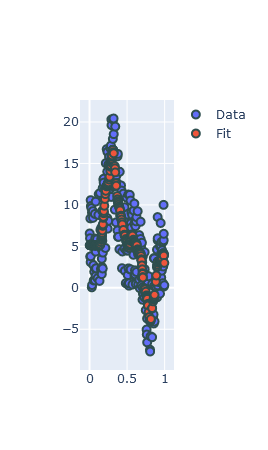

Violated Constraints: 11 from 35 


StarModel(s(1)={'constraint': 'peak-and-valley', 'knot_type': 'equidistant',
                'lam': {'constraint': 10000, 'smoothness': 0.01},
                'n_param': 35})

In [24]:
import numpy as np
from stareg.star_model import StarModel
x = np.random.random(250)
x.sort()
noise = np.random.random(250)*2.25
y = 10*np.exp(-(x-0.3)**2 / 0.01 ) - 8*np.exp(-(x-0.8)**2/0.01) + 5*noise #+ 10*x
#px.scatter(x=x, y=y)
n_param = 35

descr = ( ("s(1)", "peak-and-valley", n_param, (0.01, 10000), "equidistant"), )
M = StarModel(description=descr)
M.fit(X=x.reshape(-1,1), y=y, plot_=True)

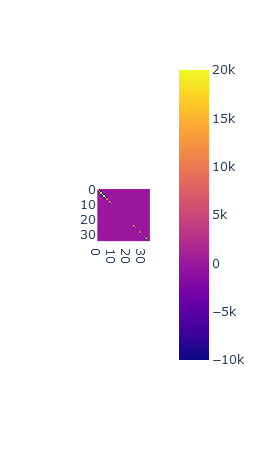

In [25]:
px.imshow(M.constraint_penalty_matrix)

In [49]:
x = np.linspace(0,1,100)
beta = -1*np.exp(-(x - 0.3)**2 / 0.01) + -1*np.exp(-(x - 0.8)**2 / 0.01)
V = check_constraint(beta=beta, constraint="multi-valley")


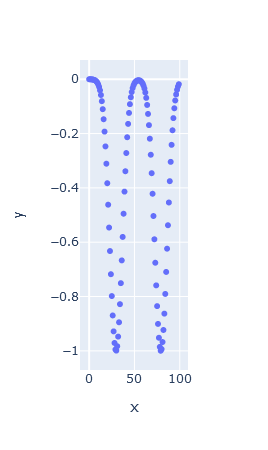

In [50]:
px.scatter(y=beta)

In [51]:
np.sum(V)

0

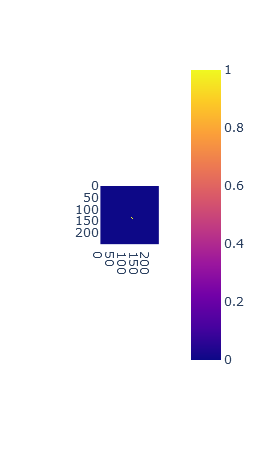

In [47]:
px.imshow(V)

In [6]:
from stareg.penalty_matrix import PenaltyMatrix
from stareg.bspline import Bspline
from scipy.linalg import block_diag
import plotly.express as px
PM = PenaltyMatrix()
#n_param = 25

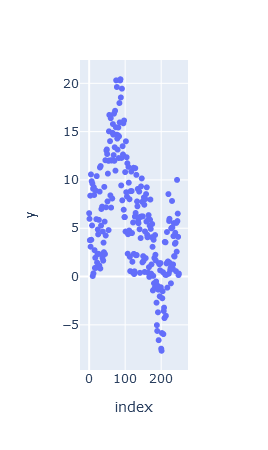

In [33]:
#x = np.linspace(0, 1, 250)
#y = np.exp(-(x - 0.1)**2 / 0.01) - np.exp(-(x-0.5)**2 / 0.01) + 0.1*noise
#y = -y
y_data = y
px.scatter(x, y=y)


In [34]:
bs = Bspline()
bs.bspline_basis(x_data=x, k=n_param, m=2, type_="equidistant")
basis = bs.basis
E = PM.multi_extremum_matrix(n_param=n_param, y_data=y_data, basis=basis)

In [35]:
peak, _ = find_peaks(x=y_data, distance=len(y_data))
valley, _ = find_peaks(x=-1*y_data, distance=len(y_data))

peakkk = np.argwhere(basis[peak[0], :] > 0)[2][0]
valleyyy = np.argwhere(basis[valley[0], :] > 0)[2][0]
middle_spline = int(np.mean([peakkk, valleyyy]))

In [36]:
middle_spline

19

In [41]:
E[valleyyy-2, valleyyy-1] = -1
E[middle_spline-2, middle_spline-1] = -1
E[peakkk-2, peakkk-1] = 1

In [42]:
peakkk

12

In [43]:
valleyyy

27

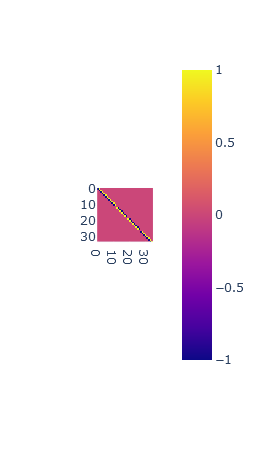

In [44]:
px.imshow(E)

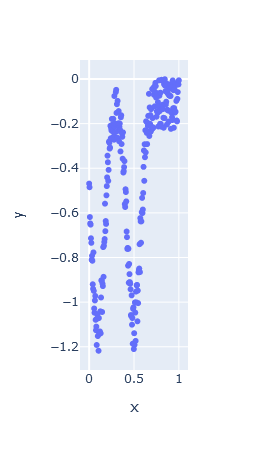

In [12]:
px.scatter(x=x, y=y)

In [21]:
basis = bs.basis

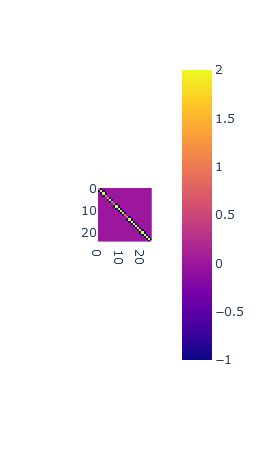

In [24]:
px.imshow(V.T@V)

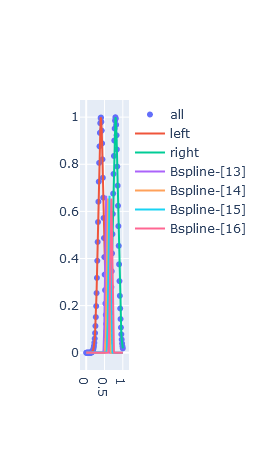

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, name="all", mode="markers"))
fig.add_trace(go.Scatter(x=x[:peaks[0]+local_valley[0]+1], y=y_data[:peaks[0]+local_valley[0]+1], name="left"))
fig.add_trace(go.Scatter(x=x[peaks[0]+local_valley[0]+1:], y=y_data[peaks[0]+local_valley[0]+1:], name="right"))
for i in loc_min:
    fig.add_trace(go.Scatter(x=x, y=basis[:,i[0]], name=f"Bspline-{i}"))
    
fig.show()
